# Plots

In [0]:
import pandas as pd
import numpy as np

from pandas.plotting import parallel_coordinates

pd.options.display.max_rows = 20
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

import gc

In [0]:
def read_table(name):
    file_root = "https://storage.googleapis.com/genx_2018/"
    return pd.read_table(file_root + name, sep="\t")

def cat_encode(src, target, col):
    cols = pd.get_dummies(src[col], prefix=col, prefix_sep='_')
    return pd.concat([target, cols], axis=1)

def drop_nan_rows(table, col):
    res = table.dropna(axis=0, how='any', subset=[col])
    print('Dropping %d nan rows for %s, sz before: %d, sz after: %d' % (len(table)-len(res), col, len(table), len(res)))
    return res

def filter(table, col, value):
    res = table.loc[table[col] != value]
    print('Filtering %d rows with "%s" for %s, sz before: %d, sz after: %d' % (len(table) - len(res), value, col, len(table), len(res)))
    return res

phenotype_meta_table = read_table("Melanoma_Phenotype_Metadata.txt")

In [0]:
# Preprocessing

# Reread table
phenotype_meta_table = read_table("Melanoma_Phenotype_Metadata.txt")

# Drop nan rows & filter

# phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'Clarks Level')  # 126 rows
# phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'Ulceration Status')  # 135 rows
phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'Tumor Stage')
phenotype_meta_table = filter(phenotype_meta_table, 'Tumor Stage', 'i/ii nos')

phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'T-stage')
phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'N-stage')
phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'M-stage')

phenotype_meta_table = filter(phenotype_meta_table, 'T-stage', 'TX')
phenotype_meta_table = filter(phenotype_meta_table, 'T-stage', 'Tis')
phenotype_meta_table = filter(phenotype_meta_table, 'N-stage', 'NX')

phenotype_meta_table = drop_nan_rows(phenotype_meta_table, 'Response To Therapy')

# Initialize pmt table

pmt = pd.DataFrame()

pmt['SampleID'] = phenotype_meta_table['SampleID']

# 0 - NO
# 1 - YES
le_bool = preprocessing.LabelEncoder()
le_bool.fit(['NO', 'YES'])

# Age
# 0 - male
# 1 - female
le_gender = preprocessing.LabelEncoder()
le_gender.fit(['male', 'female'])
# pmt['Gender'] = le_gender.transform(phenotype_meta_table['Gender'])

#pmt['Age At Diagnosis (Years)'] = phenotype_meta_table['Age At Diagnosis (Years)']

# Vital Status
# 0 - dead
# 1 - alive
le_vs = preprocessing.LabelEncoder()
le_vs.fit(['dead', 'alive'])
# pmt['Vital Status'] = le_vs.transform(phenotype_meta_table['Vital Status'])

#pmt['Breslow Depth Value'] = phenotype_meta_table['Breslow Depth Value']

# Tumor Stage
# i/ii nos -> -1 ???
# stage iiia -> 3
def tumor_stage(stage):
    if (stage == 'i/ii nos'):
        return -1
    elif (stage == 'stage 0'):
        return 0
    elif (stage in ['stage i', 'stage ia', 'stage ib']):
        return 1
    elif (stage in ['stage ii', 'stage iia', 'stage iib', 'stage iic']):
        return 2
    elif (stage in ['stage iii', 'stage iiia', 'stage iiib', 'stage iiic']):
        return 3
    elif (stage == 'stage iv'):
        return 4

pmt['Tumor Stage'] = phenotype_meta_table['Tumor Stage'].apply(lambda ts: tumor_stage(ts))
    
# TX, NX - no data, filtered
def tnm_stage(tnm):
    if (tnm in ['T0', 'N0', 'M0']):
        return 0
    elif (tnm.startswith('T1')) or (tnm.startswith('N1')) or (tnm.startswith('M1')):
        return 1
    elif (tnm.startswith('T2')) or (tnm.startswith('N2')):
        return 2
    elif (tnm.startswith('T3')) or (tnm.startswith('N3')):
        return 3
    elif (tnm.startswith('T4')):
        return 4

pmt['T-stage'] = phenotype_meta_table['T-stage'].apply(lambda tnm: tnm_stage(tnm))
pmt['N-stage'] = phenotype_meta_table['N-stage'].apply(lambda tnm: tnm_stage(tnm))
pmt['M-stage'] = phenotype_meta_table['M-stage'].apply(lambda tnm: tnm_stage(tnm))

target_map = {
 "Complete Response": 0,
 "Clinical Progressive Disease": 1,
 "Radiographic Progressive Disease": 1,    
 "Stable Disease": 1,                      
 "Partial Response": 0   
}
pmt['Response To Therapy'] = phenotype_meta_table['Response To Therapy'].apply(lambda x: target_map[x])

pmt.head(10)

Dropping 39 nan rows for Tumor Stage, sz before: 476, sz after: 437
Filtering 14 rows with "i/ii nos" for Tumor Stage, sz before: 437, sz after: 423
Dropping 2 nan rows for T-stage, sz before: 423, sz after: 421
Dropping 0 nan rows for N-stage, sz before: 421, sz after: 421
Dropping 6 nan rows for M-stage, sz before: 421, sz after: 415
Filtering 31 rows with "TX" for T-stage, sz before: 415, sz after: 384
Filtering 8 rows with "Tis" for T-stage, sz before: 384, sz after: 376
Filtering 26 rows with "NX" for N-stage, sz before: 376, sz after: 350
Dropping 278 nan rows for Response To Therapy, sz before: 350, sz after: 72


,SampleID,Tumor Stage,T-stage,N-stage,M-stage,Response To Therapy
27,TCGA-D3-A1Q1-06,3,1,3,0,1
28,TCGA-D3-A1Q3-06,2,4,0,0,0
35,TCGA-D3-A1Q9-06,3,4,2,0,1
36,TCGA-D3-A1QA-06,1,2,0,0,1
37,TCGA-D3-A1QA-07,1,2,0,0,1
55,TCGA-D3-A2JP-06,3,0,3,0,0
66,TCGA-D3-A3ML-06,3,3,2,0,1
70,TCGA-D3-A3MV-06,3,2,2,0,1
74,TCGA-D3-A51H-06,3,1,3,0,0
79,TCGA-D3-A51T-06,3,4,1,0,0


### CNV

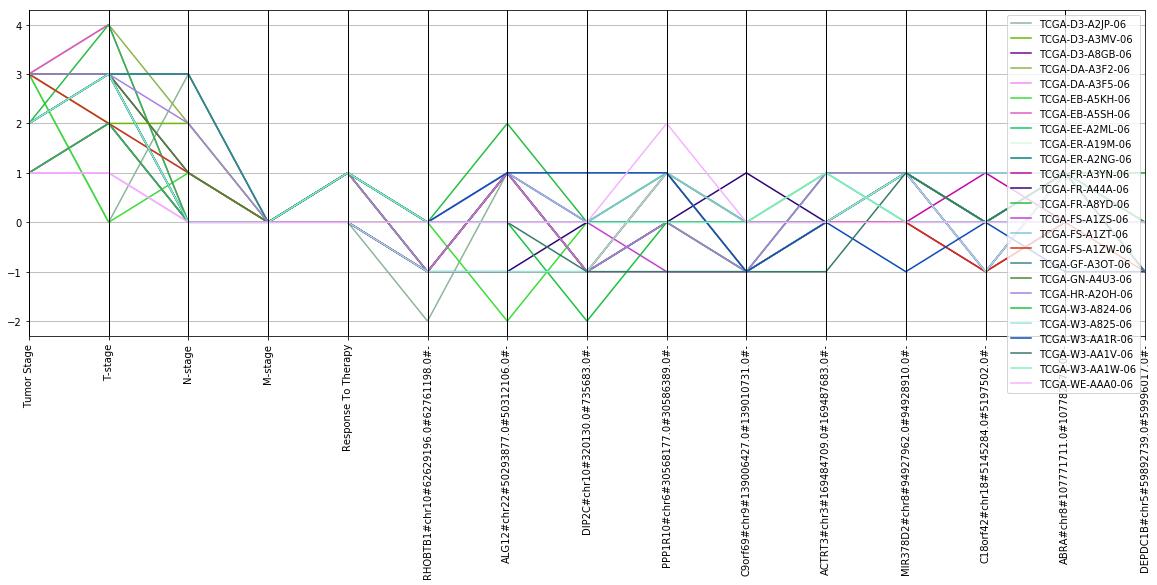

In [0]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

cnv = pd.read_pickle('cnv-').reset_index()
to_display = pmt.merge(cnv, how='inner', on='SampleID')
parallel_coordinates(to_display, 'SampleID')

### GE

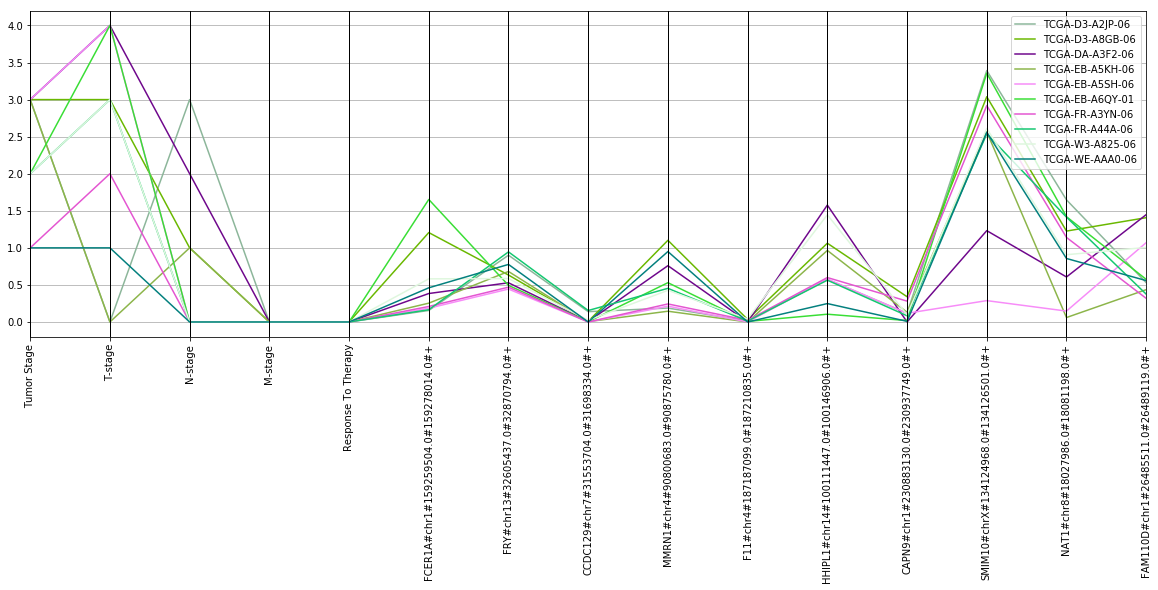

In [0]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

filtered = pmt.loc[pmt['Response To Therapy'] == 0]

ge = pd.read_pickle('ge-').reset_index()
to_display = filtered.merge(ge, how='inner', on='SampleID')
parallel_coordinates(to_display, 'SampleID')

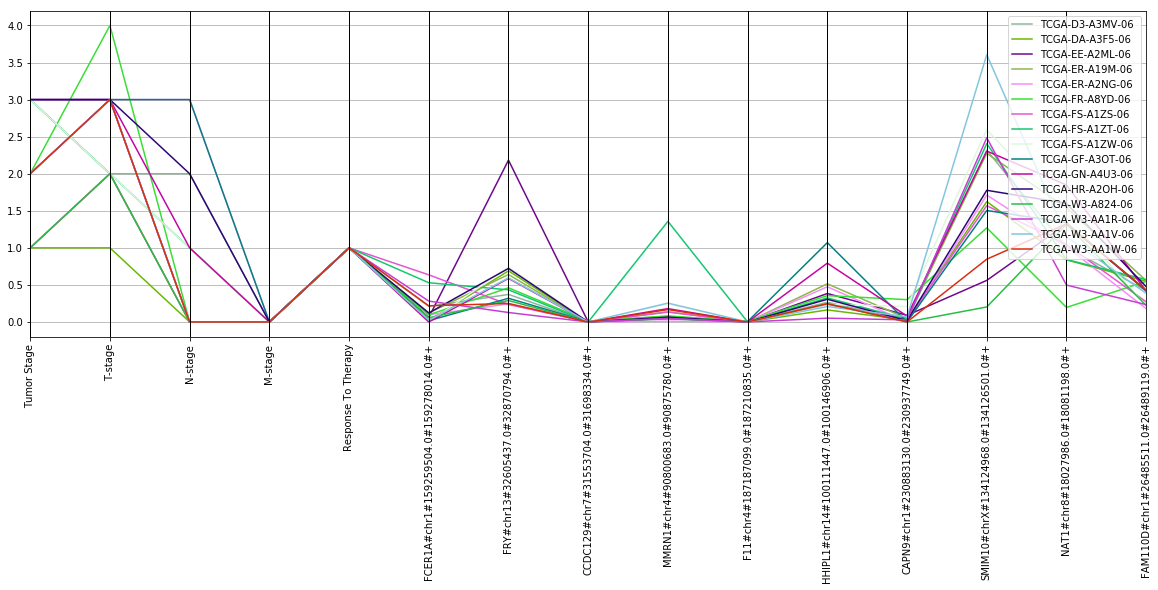

In [0]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

filtered = pmt.loc[pmt['Response To Therapy'] == 1]

ge = pd.read_pickle('ge-').reset_index()
to_display = filtered.merge(ge, how='inner', on='SampleID')
parallel_coordinates(to_display, 'SampleID')

In [0]:
def plot_important_features(pickle):
    to_display = pmt.merge(pickle, how='inner', on='SampleID')

    for col in to_display.iloc[:,6:11].columns:
        x = to_display[['Tumor Stage']]
        y = to_display[[col]]
        c = to_display[['Response To Therapy']]

        plt.scatter(x, y, c=c)
        plt.title(col)
        plt.show()

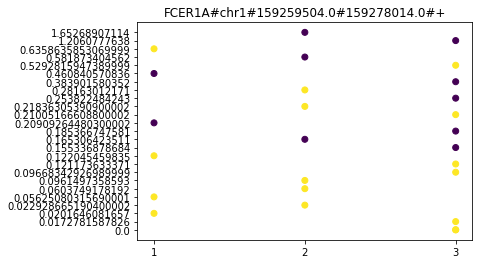

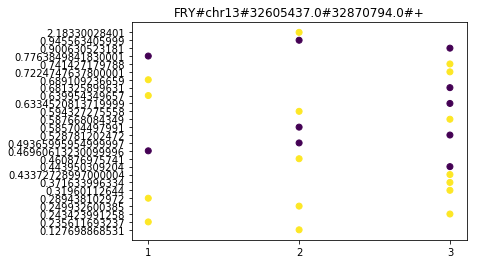

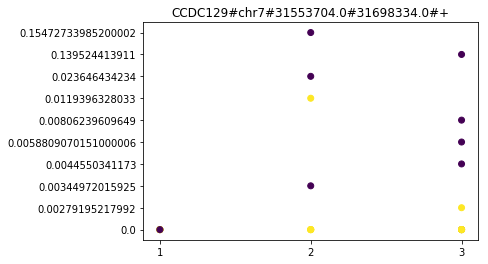

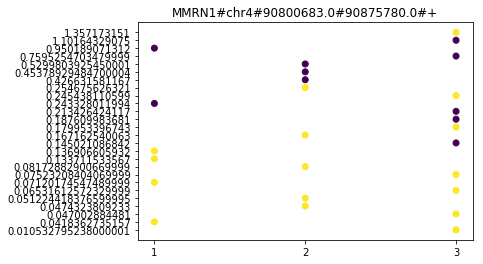

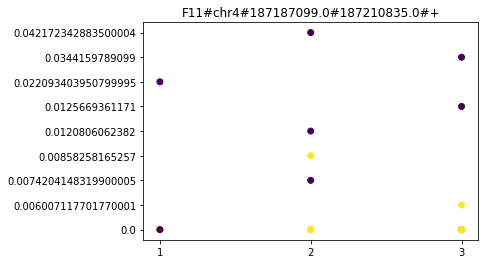

In [0]:
plot_important_features(pd.read_pickle('ge-').reset_index())

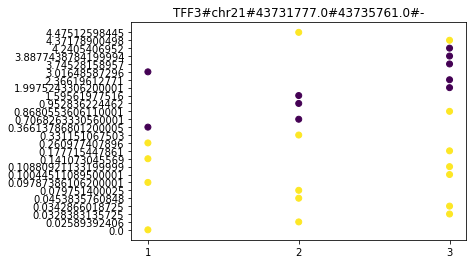

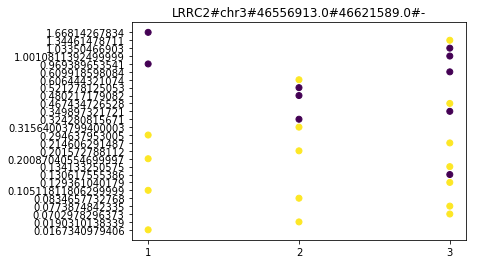

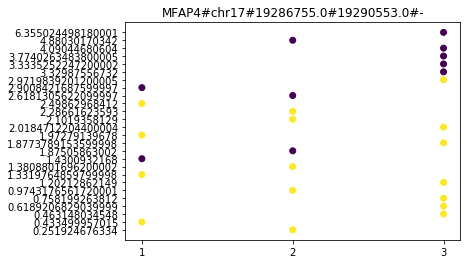

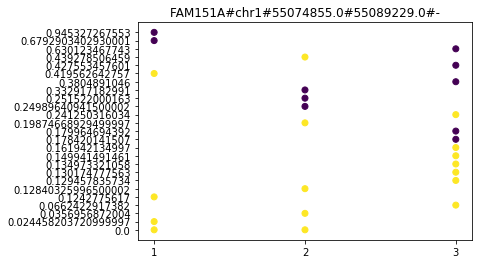

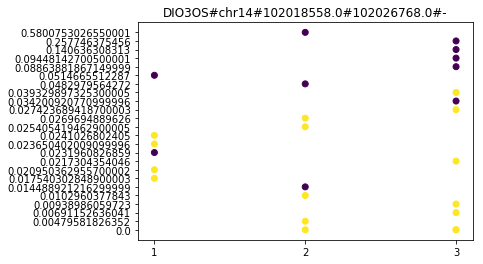

In [0]:
plot_important_features(pd.read_pickle('ge+').reset_index())

### mRNA

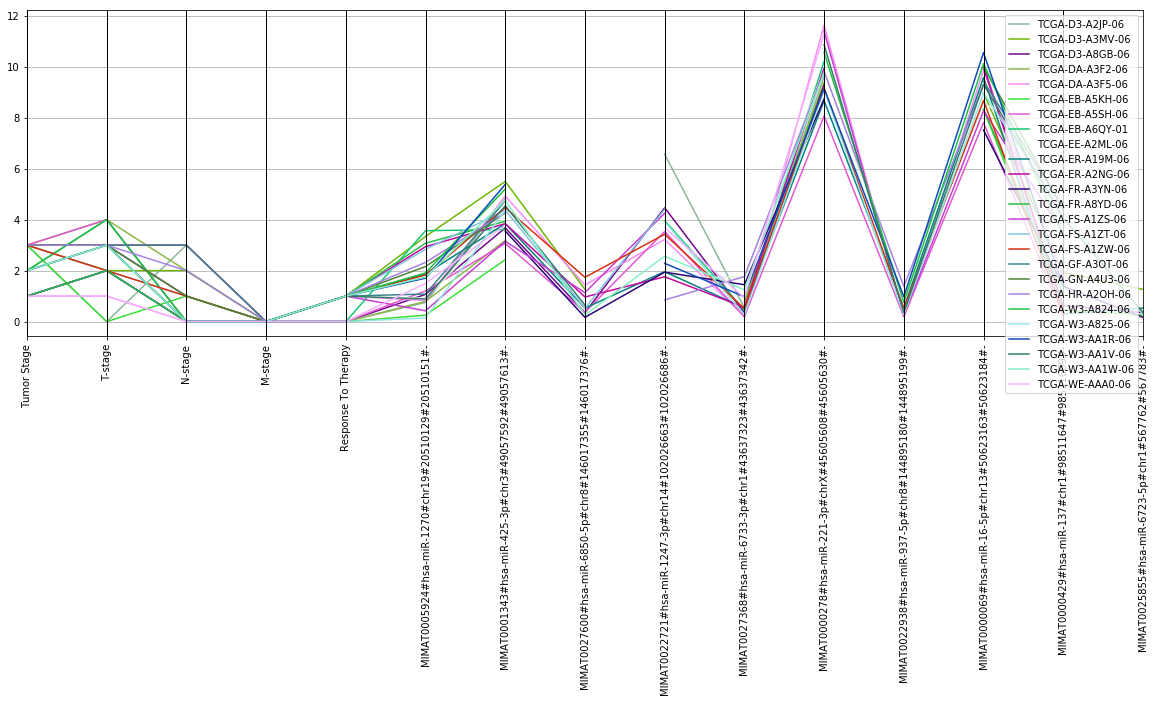

In [0]:
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)

# filtered = pmt.loc[pmt['Response To Therapy'] == 1]
filtered = pmt

mrna = pd.read_pickle('mrna-').reset_index()
to_display = filtered.merge(mrna, how='inner', on='SampleID')
parallel_coordinates(to_display, 'SampleID')